# Business Problem

Tom Jones, our client, is looking to invest in some real estate to diversify his investment portfolio. He currently owns a business that has offices throughout Texas, and he wants to invest in properties that are close to where he already has to travel for work so that he can easily visit the properties if he needed or wanted to. Tom says that he doesn't need an exact number of areas per se, but wants to know where some of the best bets are within the metro areas he frequents.

Our goal is to show Tom where the best opportunities to invest his money are. We'll do this by finding areas that have had some recent high growth and create SARIMA models to forecast future home prices. The forecasts that show the most growth in expected future value for each zipcode will be recommended as investment opportunities. 

Tom's business has offices in Austin, Dallas, Fort Worth, Houston, El Paso, San Antonio and McAllen.

To start, we'll import some tools we'll use throughout our analysis.

In [93]:
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline

## Narrowing Our Data Set

Now we'll load in our data set from Zillow and see what we have at our disposal. We already know that this table has the mean value of the home prices in a given zipcode, measured on the first of each month.

In [2]:
df = pd.read_csv('Phase 4 Project/zillow_data.csv')

df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


Looking through the .head() output and the .info() output, we can see that we have data from throughout the country, and different levels of specificity with which we can break down our search. The way we'll narrow down our search is by selecting the metro areas that Tom's offices are located in, and then ultimately narrow down to which zipcodes Tom should look at to invest (upon some research, RegionName means Zipcode in this case. We'll update the column name for clarity). 

The reason we'll do Metro instead of City is because there are lots of suburbs that have different levels of development and potential surrounding the city. For example, Plano is within the DFW metro area and is a reasonable drive from Dallas, and Plano could provide some great investment opportunities even though it's not in Dallas city limits. 

To start our narrowing, let's select only price information from the state of Texas.

In [4]:
#RegionName = zipcode

df_tx = df[df['State'] == 'TX']
df_tx.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
df_tx

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


RegionID  Zipcode           City State              Metro CountyName  \
1         90668    75070       McKinney    TX  Dallas-Fort Worth     Collin   
2         91982    77494           Katy    TX            Houston     Harris   
4         93144    79936        El Paso    TX            El Paso    El Paso   
5         91733    77084        Houston    TX            Houston     Harris   
8         91940    77449           Katy    TX            Houston     Harris   
...         ...      ...            ...   ...                ...        ...   
14372     91640    76941        Mertzon    TX         San Angelo      Irion   
14472     92897    79313          Anton    TX          Levelland    Hockley   
14492     92921    79355         Plains    TX                NaN     Yoakum   
14599     92929    79366  Ransom Canyon    TX            Lubbock    Lubbock   
14695     91948    77457      Matagorda    TX           Bay City  Matagorda   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
1             2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2             3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
4             5   77300.0   77300.0   77300.0  ...   119100   119400   120000   
5             6   95000.0   95200.0   95400.0  ...   157900   158700   160200   
8             9   95400.0   95600.0   95800.0  ...   166800   167400   168400   
...         ...       ...       ...       ...  ...      ...      ...      ...   
14372     14373       NaN       NaN       NaN  ...   122500   121800   121600   
14472     14473       NaN       NaN       NaN  ...    55400    56300    55700   
14492     14493       NaN       NaN       NaN  ...   100500   100500   101000   
14599     14600  134500.0  134500.0  134400.0  ...   252100   251600   251600   
14695     14696   90700.0   91000.0   91200.0  ...   250400   253300   256900   

       2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
1       314100   315000   316600   318100   319600   321100   321800  
2       320400   320800   321200   321200   323000   326900   329900  
4       120300   120300   120300   120300   120500   121000   121500  
5       161900   162800   162800   162800   162900   163500   164300  
8       169600   170900   172300   173300   174200   175400   176200  
...        ...      ...      ...      ...      ...      ...      ...  
14372   122200   123500   124700   124300   122600   121600   121600  
14472    56300    58900    61500    63000    63600    63500    63300  
14492   100700    99700    97700    95800    94600    94000    93500  
14599   251500   251300   251500   251700   252500   255000   257500  
14695   256100   250700   243200   238300   234200   230500   227300  

[989 rows x 272 columns]

Now, we'll use .value_counts() to see all of the values in the Metro column. Because Tom's business has office in some of the biggest cities in Texas, it's likely we'll easily find the metro names we need toward the top of the list.

In [5]:
df_tx['Metro'].value_counts()

Dallas-Fort Worth    217
Houston              187
San Antonio           78
Austin                73
Corpus Christi        22
Beaumont              21
El Paso               21
Killeen               19
Waco                  16
Lubbock               15
Tyler                 15
Wichita Falls         12
Athens                11
Longview              11
McAllen               11
Abilene               11
College Station       11
Amarillo              11
Brownsville           10
Texarkana              7
Marshall               6
Odessa                 6
San Angelo             5
Victoria               5
Huntsville             4
Midland                4
Laredo                 4
El Campo               4
Nacogdoches            3
Port Lavaca            3
Corsicana              3
Brownwood              3
Bay City               3
Palestine              3
Brenham                3
Levelland              2
Kerrville              2
Mineral Wells          2
Plainview              2
Lufkin                 2


Interestingly, Dallas and Fort Worth are lumped together in this data set. 

Now we'll make a new table that has just price information in our desired metros.

In [6]:
desired_metros = ['Dallas-Fort Worth','Houston','San Antonio','Austin','McAllen','El Paso']

tx_metros = df_tx[df_tx['Metro'].isin(desired_metros)]

tx_metros

RegionID  Zipcode       City State              Metro CountyName  \
1         90668    75070   McKinney    TX  Dallas-Fort Worth     Collin   
2         91982    77494       Katy    TX            Houston     Harris   
4         93144    79936    El Paso    TX            El Paso    El Paso   
5         91733    77084    Houston    TX            Houston     Harris   
8         91940    77449       Katy    TX            Houston     Harris   
...         ...      ...        ...   ...                ...        ...   
13442     92283    78147       Poth    TX        San Antonio     Wilson   
13893     92231    78056       Mico    TX        San Antonio     Medina   
13922     91222    76064   Maypearl    TX  Dallas-Fort Worth      Ellis   
14174     92561    78623    Fischer    TX        San Antonio      Comal   
14248     92039    77577  Liverpool    TX            Houston   Brazoria   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
1             2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2             3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
4             5   77300.0   77300.0   77300.0  ...   119100   119400   120000   
5             6   95000.0   95200.0   95400.0  ...   157900   158700   160200   
8             9   95400.0   95600.0   95800.0  ...   166800   167400   168400   
...         ...       ...       ...       ...  ...      ...      ...      ...   
13442     13443   63800.0   63800.0   63900.0  ...   135800   136700   138000   
13893     13894  178500.0  178500.0  178400.0  ...   373500   374500   379200   
13922     13923   83800.0   84000.0   84100.0  ...   163100   165100   170600   
14174     14175  141700.0  141800.0  141900.0  ...   256100   254100   253900   
14248     14249   60700.0   61100.0   61400.0  ...   155700   151300   147400   

       2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
1       314100   315000   316600   318100   319600   321100   321800  
2       320400   320800   321200   321200   323000   326900   329900  
4       120300   120300   120300   120300   120500   121000   121500  
5       161900   162800   162800   162800   162900   163500   164300  
8       169600   170900   172300   173300   174200   175400   176200  
...        ...      ...      ...      ...      ...      ...      ...  
13442   139300   140700   141400   140900   139900   139400   139500  
13893   376800   362200   345400   336400   331100   328300   326600  
13922   173500   172300   170500   169400   169300   171300   174200  
14174   255500   257700   260900   262700   267100   276100   283300  
14248   146500   145900   145600   145000   145100   147300   149200  

[587 rows x 272 columns]

In [7]:
tx_metros['Metro'].value_counts() #to double check we got what we wanted

Dallas-Fort Worth    217
Houston              187
San Antonio           78
Austin                73
El Paso               21
McAllen               11
Name: Metro, dtype: int64

As part of more pre-selection, we're going to try and find the best investment opportunity by seeing which areas have had some recent growth. We'll determine that by calculating the return on investment for each zipcode over the last 5 years.

In [8]:
#find 5 year ROI as part of further pre-screeening before we start forecasting

tx_metros['5_year_ROI'] = round((tx_metros['2018-04'] - tx_metros['2013-01']) / tx_metros['2013-01'],4)

/tmp/ipykernel_649/973311080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_metros['5_year_ROI'] = round((tx_metros['2018-04'] - tx_metros['2013-01']) / tx_metros['2013-01'],4)


In [9]:
tx_metros['5_year_ROI'].value_counts() #confirm values were created

0.2975    3
0.4953    2
0.5055    2
0.4910    2
0.5666    2
         ..
0.4047    1
0.2842    1
0.3933    1
0.3438    1
0.4426    1
Name: 5_year_ROI, Length: 563, dtype: int64

Now that we have the data we need for our forecasting, we can remove some of the columns we don't need for our analysis.

In [10]:
tx_metros.drop(['RegionID', 'City', 'State', 'SizeRank','CountyName'], axis=1, inplace=True)

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
tx_metros.head()

Zipcode              Metro   1996-04   1996-05   1996-06   1996-07  \
1    75070  Dallas-Fort Worth  235700.0  236900.0  236700.0  235400.0   
2    77494            Houston  210400.0  212200.0  212200.0  210700.0   
4    79936            El Paso   77300.0   77300.0   77300.0   77300.0   
5    77084            Houston   95000.0   95200.0   95400.0   95700.0   
8    77449            Houston   95400.0   95600.0   95800.0   96100.0   

    1996-08   1996-09   1996-10   1996-11  ...  2017-08  2017-09  2017-10  \
1  233300.0  230600.0  227300.0  223400.0  ...   310000   312500   314100   
2  208300.0  205500.0  202500.0  199800.0  ...   320600   320200   320400   
4   77400.0   77500.0   77600.0   77700.0  ...   119400   120000   120300   
5   95900.0   96100.0   96200.0   96100.0  ...   158700   160200   161900   
8   96400.0   96700.0   96800.0   96800.0  ...   167400   168400   169600   

   2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  5_year_ROI  
1   315000   316600   318100   319600   321100   321800      0.5629  
2   320800   321200   321200   323000   326900   329900      0.2842  
4   120300   120300   120300   120500   121000   121500      0.0752  
5   162800   162800   162800   162900   163500   164300      0.4617  
8   170900   172300   173300   174200   175400   176200      0.5021  

[5 rows x 268 columns]

In [12]:
tx_metros.dropna()

Zipcode              Metro   1996-04   1996-05   1996-06   1996-07  \
1        75070  Dallas-Fort Worth  235700.0  236900.0  236700.0  235400.0   
2        77494            Houston  210400.0  212200.0  212200.0  210700.0   
4        79936            El Paso   77300.0   77300.0   77300.0   77300.0   
5        77084            Houston   95000.0   95200.0   95400.0   95700.0   
8        77449            Houston   95400.0   95600.0   95800.0   96100.0   
...        ...                ...       ...       ...       ...       ...   
13442    78147        San Antonio   63800.0   63800.0   63900.0   63900.0   
13893    78056        San Antonio  178500.0  178500.0  178400.0  178500.0   
13922    76064  Dallas-Fort Worth   83800.0   84000.0   84100.0   84300.0   
14174    78623        San Antonio  141700.0  141800.0  141900.0  142000.0   
14248    77577            Houston   60700.0   61100.0   61400.0   61800.0   

        1996-08   1996-09   1996-10   1996-11  ...  2017-08  2017-09  2017-10  \
1      233300.0  230600.0  227300.0  223400.0  ...   310000   312500   314100   
2      208300.0  205500.0  202500.0  199800.0  ...   320600   320200   320400   
4       77400.0   77500.0   77600.0   77700.0  ...   119400   120000   120300   
5       95900.0   96100.0   96200.0   96100.0  ...   158700   160200   161900   
8       96400.0   96700.0   96800.0   96800.0  ...   167400   168400   169600   
...         ...       ...       ...       ...  ...      ...      ...      ...   
13442   63900.0   63900.0   63900.0   63900.0  ...   136700   138000   139300   
13893  178600.0  178800.0  179000.0  179300.0  ...   374500   379200   376800   
13922   84500.0   84700.0   84800.0   85000.0  ...   165100   170600   173500   
14174  142200.0  142200.0  142300.0  142300.0  ...   254100   253900   255500   
14248   62100.0   62500.0   62900.0   63300.0  ...   151300   147400   146500   

       2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  5_year_ROI  
1       315000   316600   318100   319600   321100   321800      0.5629  
2       320800   321200   321200   323000   326900   329900      0.2842  
4       120300   120300   120300   120500   121000   121500      0.0752  
5       162800   162800   162800   162900   163500   164300      0.4617  
8       170900   172300   173300   174200   175400   176200      0.5021  
...        ...      ...      ...      ...      ...      ...         ...  
13442   140700   141400   140900   139900   139400   139500      0.4607  
13893   362200   345400   336400   331100   328300   326600      0.1120  
13922   172300   170500   169400   169300   171300   174200      0.4163  
14174   257700   260900   262700   267100   276100   283300      0.4778  
14248   145900   145600   145000   145100   147300   149200      0.4772  

[573 rows x 268 columns]

## EDA

Let's take a look at the average ROI for each metro over the last 5 years, just to see where some of the best opportunities might be on a broader scale.

In [13]:
DeepnoteChart(tx_metros, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"bar","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":null,"type":"nominal","field":"Metro","scale":{"type":"linear"}},"y":{"sort":null,"type":"quantitative","field":"5_year_ROI","scale":{"type":"linear"},"aggregate":"average"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

It looks like El Paso doesn't have many prospects for growth, on average. So we'll remove it from consideration.

In [14]:
new_best_metros = ['Dallas-Fort Worth','Houston','Austin','McAllen','San Antonio']

best_metros = tx_metros[tx_metros['Metro'].isin(new_best_metros)]

best_metros['Zipcode'].astype(str)


1        75070
2        77494
5        77084
8        77449
18       78660
         ...  
13442    78147
13893    78056
13922    76064
14174    78623
14248    77577
Name: Zipcode, Length: 566, dtype: object

In [15]:
best_metros['Metro'].value_counts()

Dallas-Fort Worth    217
Houston              187
San Antonio           78
Austin                73
McAllen               11
Name: Metro, dtype: int64

To continue our analysis, it'll be useful to turn our data side from its current wide format into a new long format. In this long format, the date columns will become the new axis, and the remaining ROI, Zipcode, and Metro values will be descriptive of each price measurement, rather than price measurements being in a giant line of new columns.

In [16]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode', 'Metro', '5_year_ROI'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [17]:
melted_data = melt_data(best_metros)

Now we'll make sure zipcodes are strings, rather than numbers that can be calculated, and ensure that our new date axis is in the format that's easiest to arse through if we need to.

In [18]:
melted_data['Zipcode'] = melted_data['Zipcode'].astype(str)

melted_data['Date'] = pd.to_datetime(melted_data['Date'], format = '%m%y')

melted_data.set_index('Date', inplace=True)

In [19]:
melted_data

Zipcode              Metro  5_year_ROI     value
Date                                                       
1996-04-01   75070  Dallas-Fort Worth      0.5629  235700.0
1996-04-01   77494            Houston      0.2842  210400.0
1996-04-01   77084            Houston      0.4617   95000.0
1996-04-01   77449            Houston      0.5021   95400.0
1996-04-01   78660             Austin      0.4375  138900.0
...            ...                ...         ...       ...
2018-04-01   78147        San Antonio      0.4607  139500.0
2018-04-01   78056        San Antonio      0.1120  326600.0
2018-04-01   76064  Dallas-Fort Worth      0.4163  174200.0
2018-04-01   78623        San Antonio      0.4778  283300.0
2018-04-01   77577            Houston      0.4772  149200.0

[148373 rows x 4 columns]

Now let's get a general trend of price movement in all of our chosen areas, just to set baseline expectations. 

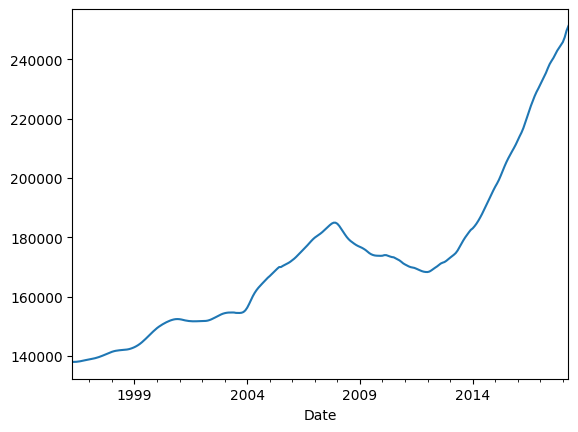

In [20]:
melted_month = melted_data.resample('MS').mean()['value']
melted_month.plot()
plt.show()

Texas metro areas have been hot markets for the last several years. The effects of the 2008 crash aren't egregious here, however I am still going to exclude anything before 2008 becuase of non-market related factors driving prices for some time. I also don't want to conveniently pick the bottom, so we'll start our forecasting from 2010, when the dust mostly settled from the 2008-2009 downturn.
This will give us 100 pieces of data with which to make forecasts, some of which have values go down, so we should have a fairly robust model with our selection of data to work from.

In [21]:
melted_data = melted_data['2010-01-01' : '2018-04-01']

In [22]:
melted_data.head() 

Zipcode              Metro  5_year_ROI     value
Date                                                       
2010-01-01   75070  Dallas-Fort Worth      0.5629  201300.0
2010-01-01   77494            Houston      0.2842  249200.0
2010-01-01   77084            Houston      0.4617  122700.0
2010-01-01   77449            Houston      0.5021  124700.0
2010-01-01   78660             Austin      0.4375  170100.0

In [23]:
melted_data.tail()

Zipcode              Metro  5_year_ROI     value
Date                                                       
2018-04-01   78147        San Antonio      0.4607  139500.0
2018-04-01   78056        San Antonio      0.1120  326600.0
2018-04-01   76064  Dallas-Fort Worth      0.4163  174200.0
2018-04-01   78623        San Antonio      0.4778  283300.0
2018-04-01   77577            Houston      0.4772  149200.0

In [24]:
melted_metro = melted_data.groupby('Metro')
melted_metro = melted_metro.value.mean()
melted_metro - melted_metro.sort_values(ascending=False)

Metro
Austin               0.0
Dallas-Fort Worth    0.0
Houston              0.0
McAllen              0.0
San Antonio          0.0
Name: value, dtype: float64

Now let's graph the average home value in the past 8 years, broken down by Metro. This can give us a general idea of where the highest priced homes will be.

<AxesSubplot: xlabel='Metro'>

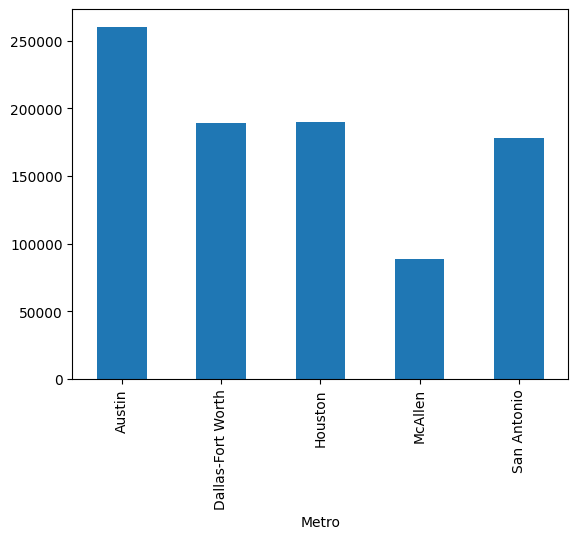

In [25]:
melted_metro.plot.bar()

This graph just about matches our expectations. Austin has the highest values, and DFW (Dallas-Fort Worth) and Houston are just about tied, with San Antonio and McAllen falling behind. No shocks here, so it's good to see we have the right expectations so far. 

To drill down one level deeper, let's see where some of the most expensive zipcodes are. We would expect DFW and Austin to have the highest priced areas.

In [26]:
melted_zips = melted_data.groupby('Zipcode')

In [27]:
melted_zips = melted_zips.value.mean()
melted_zips = melted_zips.sort_values(ascending=False).head(20)

<AxesSubplot: xlabel='Zipcode'>

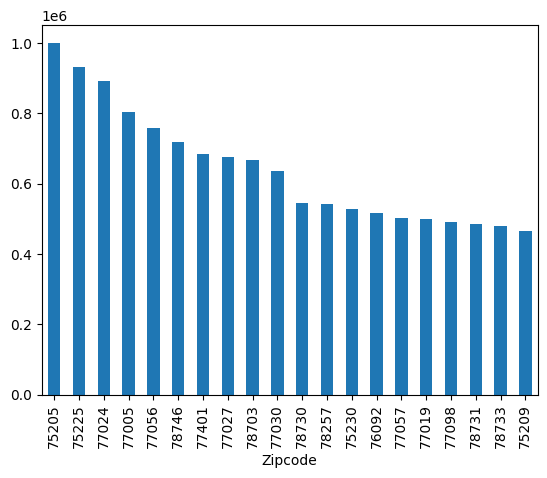

In [28]:
melted_zips.plot.bar()

Once again, this chart matches our expectations. The zipcodes for Park Cities in uptown Dallas are at the top, followed shortly by developed parts of Austin and Houston. 

What will be interesting to see, though, is if these also make up some of the areas with the most growth in recent years. Intuitively, you would think that the richest and most developed parts of a city would be in very high demand, leading to growth over time.

Additionally, we will be using the top 20 zipcodes by ROI to do our forecasting. 

In [29]:
melted_data['5_year_ROI'].describe()

count    56488.000000
mean         0.492670
std          0.168103
min          0.097300
25%          0.378300
50%          0.479100
75%          0.576800
max          1.098500
Name: 5_year_ROI, dtype: float64

Text(0, 0.5, 'ROI %')

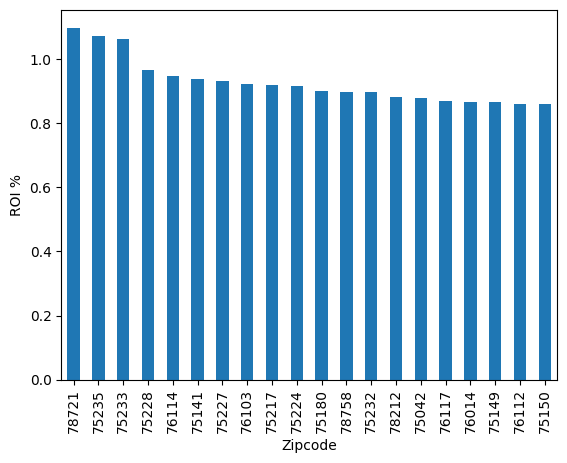

In [30]:
melted_roi = melted_data.groupby('Zipcode')
melted_roi = melted_roi['5_year_ROI'].mean()
melted_roi = melted_roi.sort_values(ascending=False).head(20)

melted_roi.plot.bar()
plt.ylabel('ROI %')


Upon review, it seems that the most expensive neighborhoods do not make up the neighborhoods with the most growth. That actually might work to our advantage, however. If the areas with the most growth don't have the highest prices, Tom could buy more individual properties and spread his risk a bit. Plus, it's likely he'll have an easier time finding a buyer whenever he wants to sell a property because it'll be in a more reasonable price range for more people, rather having to stick to ultra wealthy buyers.

Now, let's take our top 20 zipcodes and use them to do our forecasting.

In [31]:
top_roi_zips = ['78721', '75235','75233', '75228', '76114', '75141', '75227', '76103', '75217', '75224', '75180', '78758', '75232', '78212', '75042', '76117', '76014', '75149', '76112', '75150']

top_zipcodes = melted_data.loc[melted_data['Zipcode'].isin(top_roi_zips)]

top_zipcodes

Zipcode              Metro  5_year_ROI     value
Date                                                       
2010-01-01   75228  Dallas-Fort Worth      0.9670   95200.0
2010-01-01   75217  Dallas-Fort Worth      0.9190   67100.0
2010-01-01   75150  Dallas-Fort Worth      0.8586   94600.0
2010-01-01   78758             Austin      0.8989  142900.0
2010-01-01   75149  Dallas-Fort Worth      0.8649   86700.0
...            ...                ...         ...       ...
2018-04-01   75180  Dallas-Fort Worth      0.8997  130700.0
2018-04-01   76103  Dallas-Fort Worth      0.9224  126300.0
2018-04-01   75233  Dallas-Fort Worth      1.0616  204100.0
2018-04-01   78721             Austin      1.0985  296100.0
2018-04-01   75141  Dallas-Fort Worth      0.9378  118400.0

[2000 rows x 4 columns]

As one last step, we want to keep our long format where the date is our axis, but have each zipcode's measurement as its own column. This will let us use the format we need to do forecasts, but iterate that process over each column to produce best-fitting models for each zipcode.

In [32]:
#reformats melted data into a format that can be looped over later

zipcode_list = top_zipcodes['Zipcode'].unique().tolist()
zipcode_columns = {}
for zipcode in zipcode_list:
    formatted_model_data = top_zipcodes.groupby('Zipcode').get_group(zipcode).sort_index()['value'].astype(int)
    zipcode_columns[zipcode] = formatted_model_data


reformatted_dataset = pd.DataFrame(zipcode_columns)
reformatted_dataset.head()

reformatted_dataset.info() #to confirm we made new columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2010-01-01 to 2018-04-01
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   75228   100 non-null    int64
 1   75217   100 non-null    int64
 2   75150   100 non-null    int64
 3   78758   100 non-null    int64
 4   75149   100 non-null    int64
 5   75227   100 non-null    int64
 6   76112   100 non-null    int64
 7   78212   100 non-null    int64
 8   75042   100 non-null    int64
 9   76117   100 non-null    int64
 10  76014   100 non-null    int64
 11  75224   100 non-null    int64
 12  75232   100 non-null    int64
 13  76114   100 non-null    int64
 14  75235   100 non-null    int64
 15  75180   100 non-null    int64
 16  76103   100 non-null    int64
 17  75233   100 non-null    int64
 18  78721   100 non-null    int64
 19  75141   100 non-null    int64
dtypes: int64(20)
memory usage: 16.4 KB


To make sure our model setup works, we will first ensure that we can set it up with one zipcode before building a function that can loop the model building process over each zipcode and print the results.

In [33]:
model_building_data = reformatted_dataset['78721']

model_building_data

Date
2010-01-01    136300
2010-02-01    136400
2010-03-01    136800
2010-04-01    137600
2010-05-01    138800
               ...  
2017-12-01    293000
2018-01-01    296300
2018-02-01    297800
2018-03-01    297200
2018-04-01    296100
Name: 78721, Length: 100, dtype: int64

In [34]:
#train test split
train_size = 0.8
split_idx = round(len(model_building_data)* train_size) #makes the first 80 of our 100 observations the training set, and last 20 as test
split_idx = split_idx

## Split
train = model_building_data.iloc[:split_idx]
test = model_building_data.iloc[split_idx:]

To build our model, we will be using the auto_arima package from pmdarima. Auto-arima works by building and trying out various SARIMA models with various p,d, and q values to determine which set of values provides the best forecast with the least possible variance in expected outcome.

SARIMA stands for Seasonal Autoregressive Integrated Moving Average.

The autoregressive part of the model determines how many previous values it takes to accurately determine the next value in the sequence. Frame it like this: if I want to know what the price of my home will be next month, how many months worth of previous data do I need to determine some sort of pattern and come to a conclusion? The value p determines how many values we will need to look back.

The integrated part of the model determines the number of nonseasonal differences needed for stationarity. Data is considered stationary when there is no noticeable trend up or down, has constant variance over time, a constant autocorrelation structure (all data points are equally related to one another), and there is no seasonality. It is easier to make predictions when data is stationary. Auto_arima is able to find a perameter value, d, that manipulates the data such that it becomes stationary. In math terms, the model will take the difference between sets values until there is a constant mean and variance. For a more thorough explanation of the math, check here: https://people.duke.edu/~rnau/411arim.htm

The moving average part of the model helps smooth the trend line we're using to make predictions. You might have head of a stock price's 180 day moving average. This value changes over time, but has much less variance (less erratic movement) and tends to move in a much more predictable fashion. Thus, it's more useful when trying to predict what a stock price will be in the future, rather than using daily measurements that can fluctuate by large amounts. Now imagine it's home prices measured every month, instead of stock prices measured every day. In our model, the exponent needed for smoothing is determined by the peramter q. 

The auto_arima package is capable of determining whether or not there is seasonality, or changes in the price at regular intervals. If there was a pattern of home prices tending to rise a lot in summer months and flatten out in winter months, there would be clear seasonality. Auto_arima would find another set of P,D and Q values much like as those described above, and then multiply those values times the number of observations in a year, in this case 12. The trend line would be smoothed out to remove any seasonality trends.

In [35]:
#model with pmdarima
auto_model = auto_arima(train,start_p=0,start_q=0)
display(auto_model.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -634.405
Date:                Fri, 17 Feb 2023   AIC                           1270.809
Time:                        02:55:07   BIC                           1273.166
Sample:                    01-01-2010   HQIC                          1271.752
                         - 08-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.791e+05   9.35e+04      7.263      0.000    4.96e+05    8.62e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.96   Jarque-Bera (JB):                 2.91
Prob(Q):                              0.09   Prob(JB):                         0.23
Heteroskedasticity (H):               3.33   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Our code ran and printed out the ideal model for the 78721 zipcode having a p value of 0, d value of 2, and q value of 0. Now that we know auto_arima can work as intended, let's set up the necessary functions to create these models over each zipcode in our modeling data.

The function directly below will allow us to take the predicted values of the average home price of a given zipcode, store its prediction as a value, and store the highest and lowest possible prediction values based on the variance seen by the model.

In [36]:
def forecast_to_df(forecast,zipcode):
    test_pred = forecast.conf_int()
    test_pred[zipcode] = forecast.predicted_mean
    test_pred.columns = ['lower','upper','prediction']
    return test_pred

The function below allows us to format the output graphs in such a way that the training set data, test set data, and forecast values and variance are all different colors and easily identifiable. 

In [37]:
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots()
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['prediction'],label='prediction',ls='--',**kws)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'])
    ax.legend(bbox_to_anchor=[1,1])
    fig.tight_layout()
    return fig,ax

Now, it's time to create 20 models, one for each zipcode in consideration, and see which zipcodes are best.

One final note: we will be using Mean Absolute Percentage Error (MAPE) to see which of our models are useful. The lower this score is, the better. To even be considered useful, a model should have a MAPE lower than 0.5.

75228
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.49865D+00    |proj g|=  1.15382D+00

At iterate    5    f=  7.42182D+00    |proj g|=  1.66017D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   1.660D-05   7.422D+00
  F =   7.4218238557091434     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provi

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75228   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -742.182
Date:                Fri, 17 Feb 2023   AIC                           1488.365
Time:                        03:44:20   BIC                           1493.535
Sample:                    01-01-2010   HQIC                          1490.456
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0814      0.047      1.729      0.084      -0.011       0.174
sigma2        2.2e+05   2.27e+04      9.700      0.000    1.76e+05    2.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.52   Jarque-Bera (JB):                20.20
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               3.29   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

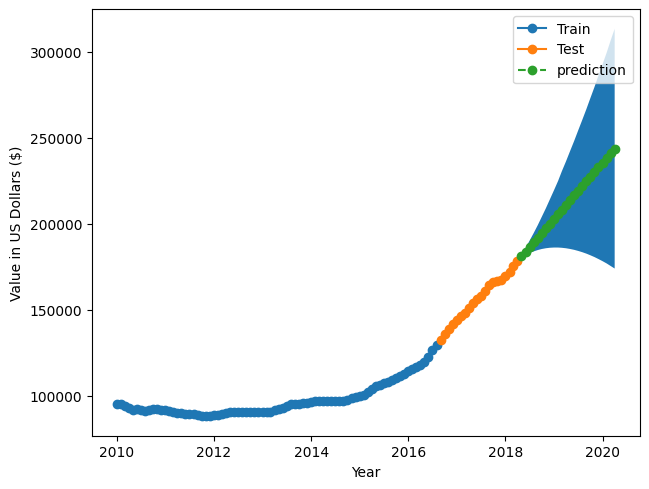

Mean Absolute Percentage Error of Above Model:
0.32364710772682065
------------------------------------------------------------

75217
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73578D+00    |proj g|=  3.11548D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   6.382D-07   7.736D+00
  F =   7.7356795782800738     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75217   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -773.568
Date:                Fri, 17 Feb 2023   AIC                           1549.136
Time:                        03:44:20   BIC                           1551.721
Sample:                    01-01-2010   HQIC                          1550.181
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.203e+05   5.08e+04      8.282      0.000    3.21e+05     5.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 3.28
Prob(Q):                              0.51   Prob(JB):                         0.19
Heteroskedasticity (H):               1.22   Skew:                            -0.18
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

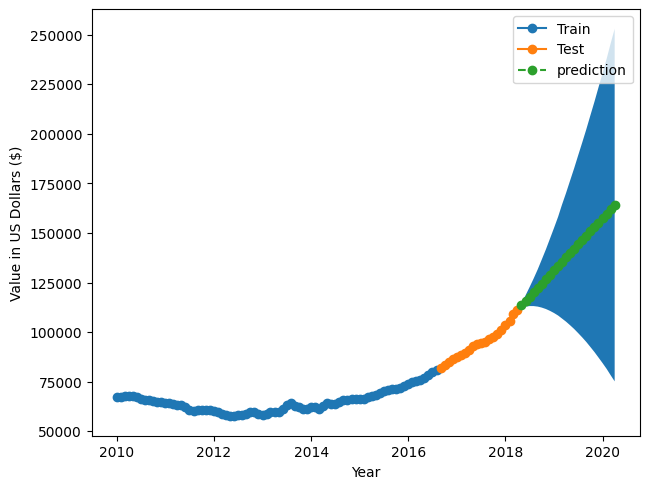

Mean Absolute Percentage Error of Above Model:
0.4187361245091993
------------------------------------------------------------

75150
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.32926D+00    |proj g|=  1.66302D+00

At iterate    5    f=  7.07171D+00    |proj g|=  1.65736D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   1.657D-04   7.072D+00
  F =   7.0717086735406092     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH            

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75150   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -707.171
Date:                Fri, 17 Feb 2023   AIC                           1418.342
Time:                        03:44:21   BIC                           1423.512
Sample:                    01-01-2010   HQIC                          1420.433
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0721      0.033      2.175      0.030       0.007       0.137
sigma2          1e+05   1.04e+04      9.624      0.000    7.96e+04     1.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.75   Jarque-Bera (JB):                13.75
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               4.25   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

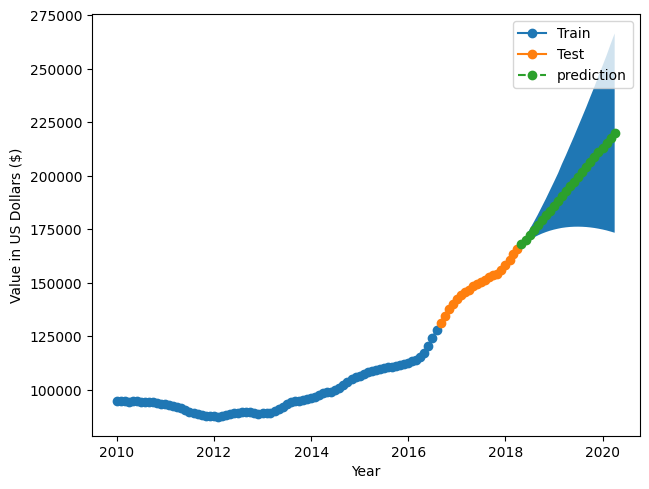

Mean Absolute Percentage Error of Above Model:
0.26752486817924187
------------------------------------------------------------

78758
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.78226D+00    |proj g|=  2.97122D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   6.141D-07   7.782D+00
  F =   7.7821545176197757     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  78758   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -778.215
Date:                Fri, 17 Feb 2023   AIC                           1558.431
Time:                        03:44:22   BIC                           1561.016
Sample:                    01-01-2010   HQIC                          1559.476
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.622e+05   5.21e+04      8.873      0.000     3.6e+05    5.64e+05
===================================================================================
Ljung-Box (L1) (Q):                  23.09   Jarque-Bera (JB):                 7.28
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               7.28   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

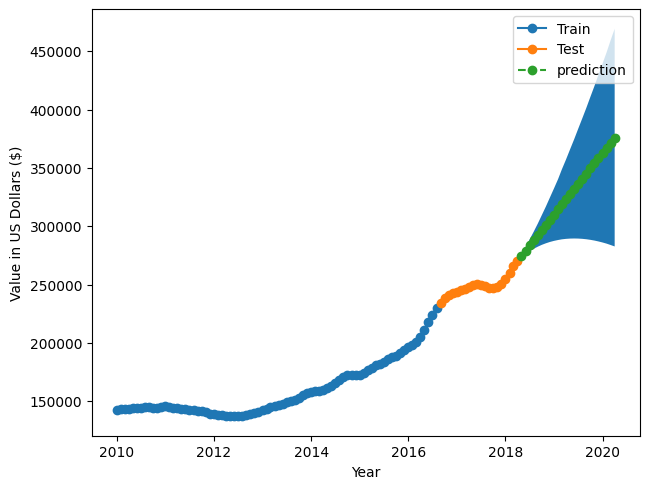

Mean Absolute Percentage Error of Above Model:
0.26924374304648163
------------------------------------------------------------

75149
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.30273D+00    |proj g|=  1.50165D+00

At iterate    5    f=  7.02392D+00    |proj g|=  2.01455D-04

At iterate   10    f=  7.02391D+00    |proj g|=  9.25571D-03

At iterate   15    f=  7.02343D+00    |proj g|=  3.76765D-02

At iterate   20    f=  7.02328D+00    |proj g|=  1.46985D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75149   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -702.328
Date:                Fri, 17 Feb 2023   AIC                           1408.657
Time:                        03:44:23   BIC                           1413.827
Sample:                    01-01-2010   HQIC                          1410.748
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1130      0.032      3.537      0.000       0.050       0.176
sigma2      9.211e+04   1.12e+04      8.237      0.000    7.02e+04    1.14e+05
===================================================================================
Ljung-Box (L1) (Q):                  10.66   Jarque-Bera (JB):                 6.14
Prob(Q):                              0.00   Prob(JB):                         0.05
Heteroskedasticity (H):               1.88   Skew:                             0.27
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

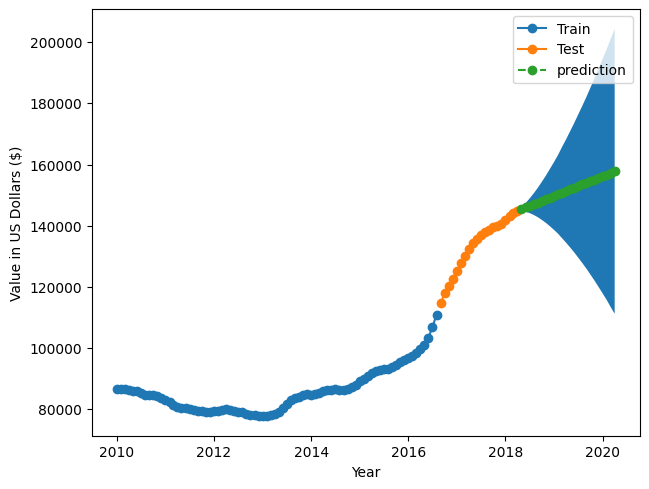

Mean Absolute Percentage Error of Above Model:
0.13189521698768006
------------------------------------------------------------

75227
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47258D+00    |proj g|=  2.64493D+00

At iterate    5    f=  7.31029D+00    |proj g|=  8.82911D-04

At iterate   10    f=  7.31025D+00    |proj g|=  1.73229D-02

At iterate   15    f=  7.30634D+00    |proj g|=  1.84709D-01

At iterate   

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75227   No. Observations:                  100
Model:               SARIMAX(3, 2, 0)   Log Likelihood                -728.700
Date:                Fri, 17 Feb 2023   AIC                           1465.400
Time:                        03:44:26   BIC                           1475.740
Sample:                    01-01-2010   HQIC                          1469.582
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0584      0.033      1.777      0.076      -0.006       0.123
ar.L2         -0.0436      0.027     -1.625      0.104      -0.096       0.009
ar.L3         -0.0992      0.030     -3.255      0.001      -0.159      -0.039
sigma2      1.523e+05   1.64e+04      9.262      0.000     1.2e+05    1.84e+05
===================================================================================
Ljung-Box (L1) (Q):                   7.31   Jarque-Bera (JB):                24.16
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.55
Prob(H) (two-sided):                  0.89   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

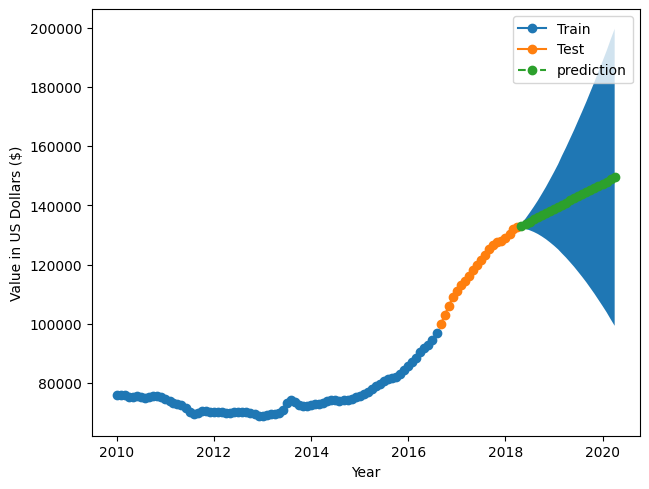

Mean Absolute Percentage Error of Above Model:
0.1776958831982835
------------------------------------------------------------

76112
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.04042D+00    |proj g|=  6.33404D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   1.056D-06   7.040D+00
  F =   7.0403203864624482     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  76112   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -704.032
Date:                Fri, 17 Feb 2023   AIC                           1410.064
Time:                        03:44:26   BIC                           1412.649
Sample:                    01-01-2010   HQIC                          1411.110
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.017e+05   1.26e+04      8.082      0.000     7.7e+04    1.26e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.77   Jarque-Bera (JB):                 1.97
Prob(Q):                              0.00   Prob(JB):                         0.37
Heteroskedasticity (H):               1.82   Skew:                            -0.08
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

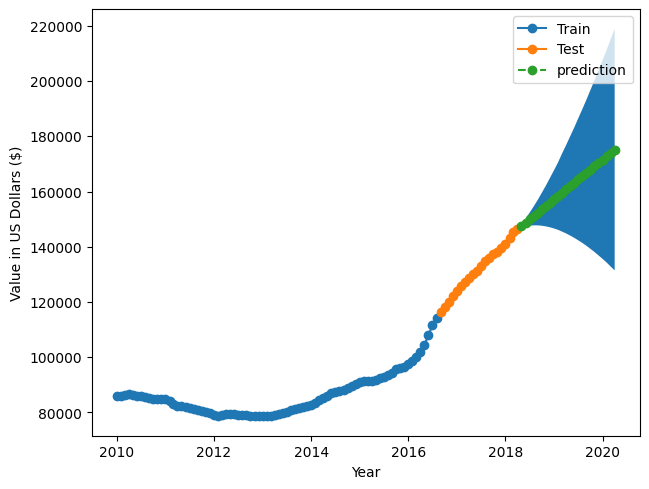

Mean Absolute Percentage Error of Above Model:
0.2067944304380493
------------------------------------------------------------

78212
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93195D+00    |proj g|=  2.55030D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   5.391D-07   7.932D+00
  F =   7.9318541335343253     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  78212   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -793.185
Date:                Fri, 17 Feb 2023   AIC                           1588.371
Time:                        03:44:27   BIC                           1590.956
Sample:                    01-01-2010   HQIC                          1589.416
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.273e+05   6.18e+04     10.143      0.000    5.06e+05    7.48e+05
===================================================================================
Ljung-Box (L1) (Q):                  29.13   Jarque-Bera (JB):                22.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.35   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

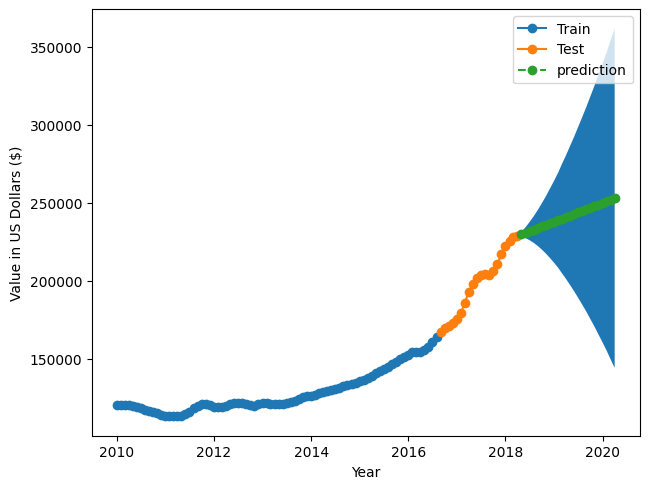

Mean Absolute Percentage Error of Above Model:
0.21668581079884608
------------------------------------------------------------

75042
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52935D+00    |proj g|=  1.79631D+00

At iterate    5    f=  7.31779D+00    |proj g|=  1.11826D-02

At iterate   10    f=  7.31613D+00    |proj g|=  1.51033D-01

At iterate   15    f=  7.30889D+00    |proj g|=  1.76770D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     25      1    

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75042   No. Observations:                  100
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -730.889
Date:                Fri, 17 Feb 2023   AIC                           1465.777
Time:                        03:44:28   BIC                           1470.947
Sample:                    01-01-2010   HQIC                          1467.868
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0731      0.029      2.528      0.011       0.016       0.130
sigma2      1.684e+05   2.32e+04      7.267      0.000    1.23e+05    2.14e+05
===================================================================================
Ljung-Box (L1) (Q):                  12.21   Jarque-Bera (JB):                 2.67
Prob(Q):                              0.00   Prob(JB):                         0.26
Heteroskedasticity (H):               1.84   Skew:                             0.38
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

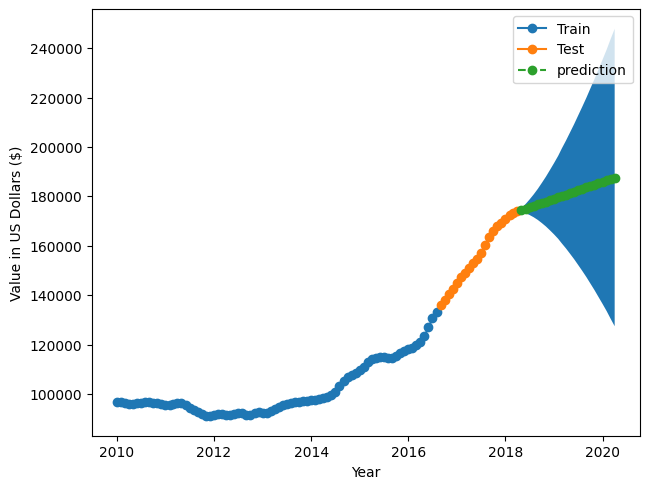

Mean Absolute Percentage Error of Above Model:
0.15455610490771188
------------------------------------------------------------

76117
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09917D+00    |proj g|=  5.96540D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   1.017D-06   7.099D+00
  F =   7.0990705354872849     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  76117   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -709.907
Date:                Fri, 17 Feb 2023   AIC                           1421.814
Time:                        03:44:29   BIC                           1424.399
Sample:                    01-01-2010   HQIC                          1422.860
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.147e+05    1.6e+04      7.174      0.000    8.33e+04    1.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.84   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.17   Prob(JB):                         0.87
Heteroskedasticity (H):               2.30   Skew:                            -0.11
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

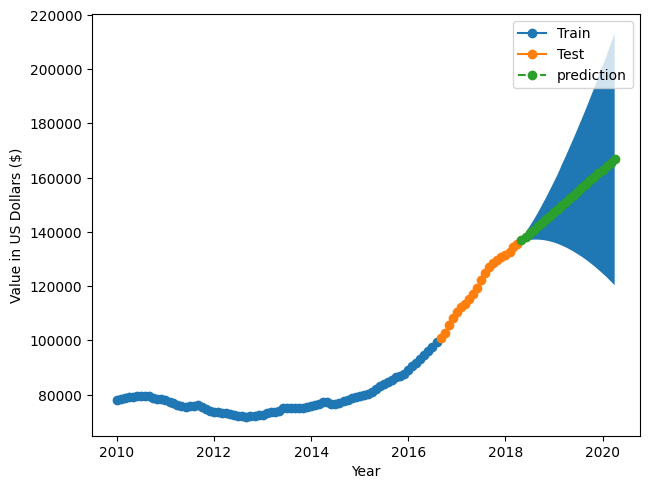

Mean Absolute Percentage Error of Above Model:
0.24735238213158822
------------------------------------------------------------

76014
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.06951D+00    |proj g|=  9.98446D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   2.696D-05   6.970D+00
  F =   6.9704706455909466     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  76014   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -697.047
Date:                Fri, 17 Feb 2023   AIC                           1398.094
Time:                        03:44:30   BIC                           1403.264
Sample:                    01-01-2010   HQIC                          1400.185
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0640      0.054      1.186      0.236      -0.042       0.170
sigma2      8.588e+04   1.05e+04      8.171      0.000    6.53e+04    1.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.23   Jarque-Bera (JB):                 3.56
Prob(Q):                              0.14   Prob(JB):                         0.17
Heteroskedasticity (H):               1.58   Skew:                            -0.25
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

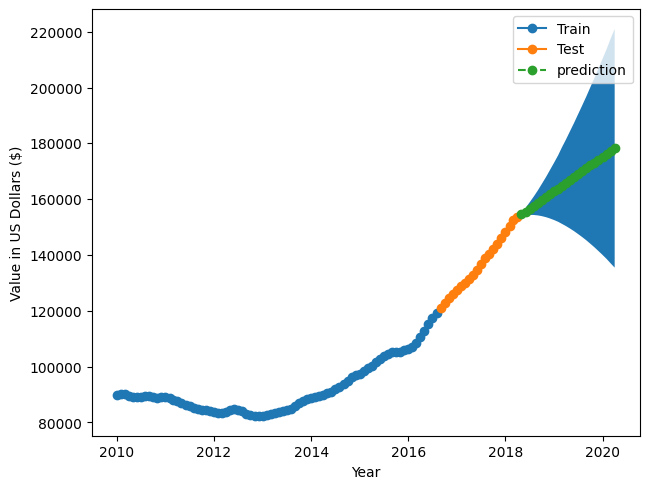

Mean Absolute Percentage Error of Above Model:
0.2064048274668601
------------------------------------------------------------

75224
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08621D+00    |proj g|=  2.41651D+00

At iterate    5    f=  7.29901D+00    |proj g|=  2.03011D-03

At iterate   10    f=  7.29884D+00    |proj g|=  2.58504D-02

At iterate   15    f=  7.28246D+00    |proj g|=  2.40670D-01

At iterate   2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75224   No. Observations:                  100
Model:               SARIMAX(5, 2, 0)   Log Likelihood                -723.393
Date:                Fri, 17 Feb 2023   AIC                           1458.787
Time:                        03:44:34   BIC                           1474.297
Sample:                    01-01-2010   HQIC                          1465.060
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1569      0.111      1.408      0.159      -0.062       0.375
ar.L2          0.1208      0.035      3.494      0.000       0.053       0.188
ar.L3         -0.1449      0.065     -2.237      0.025      -0.272      -0.018
ar.L4         -0.0882      0.077     -1.141      0.254      -0.240       0.063
ar.L5          0.0636      0.035      1.797      0.072      -0.006       0.133
sigma2      1.715e+05   3.05e+04      5.615      0.000    1.12e+05    2.31e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):                 1.98
Prob(Q):                              0.29   Prob(JB):                         0.37
Heteroskedasticity (H):               1.05   Skew:                             0.10
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

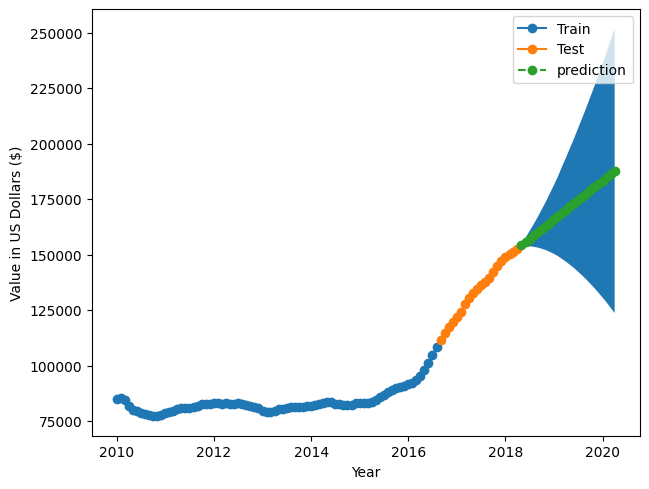

Mean Absolute Percentage Error of Above Model:
0.2569600567459619
------------------------------------------------------------

75232
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82616D+00    |proj g|=  1.28686D+00

At iterate    5    f=  7.29592D+00    |proj g|=  6.56794D-03

At iterate   10    f=  7.29437D+00    |proj g|=  1.16903D-01

At iterate   15    f=  7.28758D+00    |proj g|=  1.58400D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     23      1     

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75232   No. Observations:                  100
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -728.758
Date:                Fri, 17 Feb 2023   AIC                           1461.516
Time:                        03:44:35   BIC                           1466.686
Sample:                    01-01-2010   HQIC                          1463.607
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0965      0.047      2.071      0.038       0.005       0.188
sigma2      1.623e+05   2.48e+04      6.544      0.000    1.14e+05    2.11e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.11   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.04   Prob(JB):                         0.76
Heteroskedasticity (H):               1.47   Skew:                             0.18
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

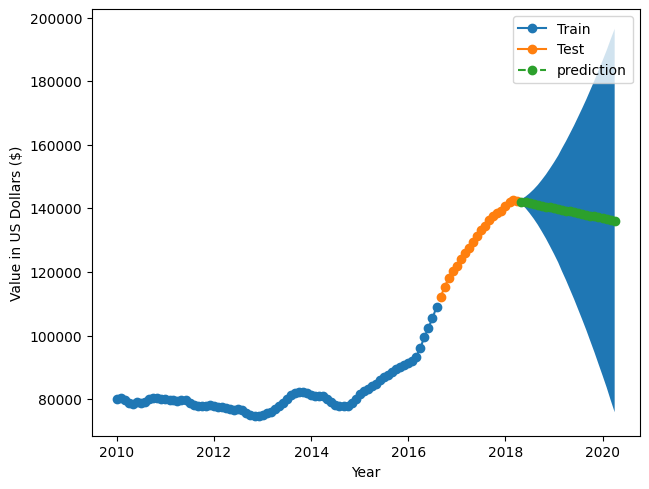

Mean Absolute Percentage Error of Above Model:
0.08825048083825295
------------------------------------------------------------

76114
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.41055D+00    |proj g|=  4.34164D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   8.270D-07   7.410D+00
  F =   7.4104485344075366     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  76114   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -741.045
Date:                Fri, 17 Feb 2023   AIC                           1484.090
Time:                        03:44:36   BIC                           1486.675
Sample:                    01-01-2010   HQIC                          1485.135
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.164e+05   2.78e+04      7.781      0.000    1.62e+05    2.71e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.64   Prob(JB):                         0.35
Heteroskedasticity (H):               2.46   Skew:                            -0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

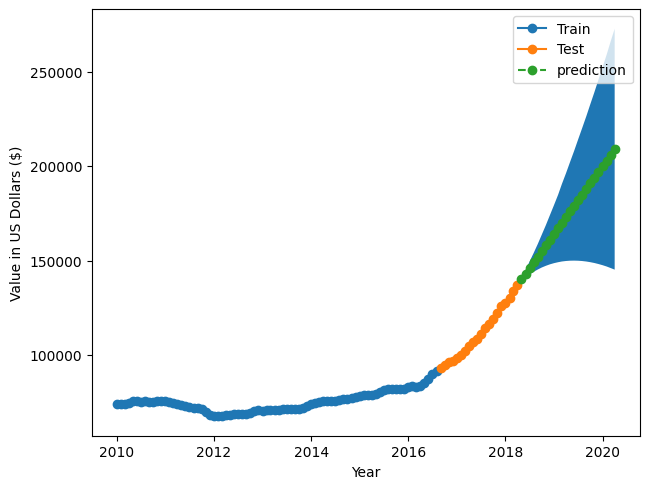

Mean Absolute Percentage Error of Above Model:
0.5097937488838236
------------------------------------------------------------

75235
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.79706D+00    |proj g|=  2.73473D+00

At iterate    5    f=  8.15733D+00    |proj g|=  2.49699D-04

At iterate   10    f=  8.15733D+00    |proj g|=  1.45223D-02

At iterate   15    f=  8.15647D+00    |proj g|=  1.33366D-01

At iterate   20    f=  8.15438D+00    |proj g|=  2.12155D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75235   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -815.438
Date:                Fri, 17 Feb 2023   AIC                           1634.876
Time:                        03:44:36   BIC                           1640.046
Sample:                    01-01-2010   HQIC                          1636.967
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0383      0.027      1.410      0.158      -0.015       0.092
sigma2      9.748e+05   9.91e+04      9.838      0.000    7.81e+05    1.17e+06
===================================================================================
Ljung-Box (L1) (Q):                  12.80   Jarque-Bera (JB):                21.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.74   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

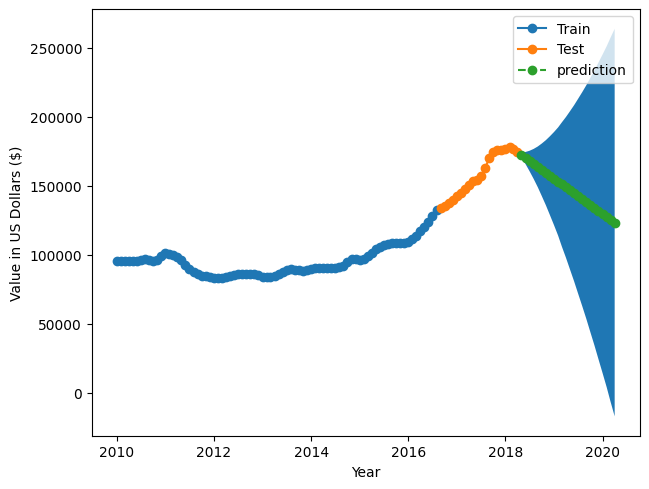

Mean Absolute Percentage Error of Above Model:
0.15638978152255162
------------------------------------------------------------

75180
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52111D+00    |proj g|=  1.01157D+00

At iterate    5    f=  7.42844D+00    |proj g|=  4.78766D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   4.788D-05   7.428D+00
  F =   7.4284365595796400     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH           

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75180   No. Observations:                  100
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -742.844
Date:                Fri, 17 Feb 2023   AIC                           1489.687
Time:                        03:44:37   BIC                           1494.857
Sample:                    01-01-2010   HQIC                          1491.778
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0883      0.074      1.195      0.232      -0.057       0.233
sigma2      2.249e+05   3.55e+04      6.331      0.000    1.55e+05    2.95e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.41   Prob(JB):                         0.85
Heteroskedasticity (H):               1.38   Skew:                            -0.14
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

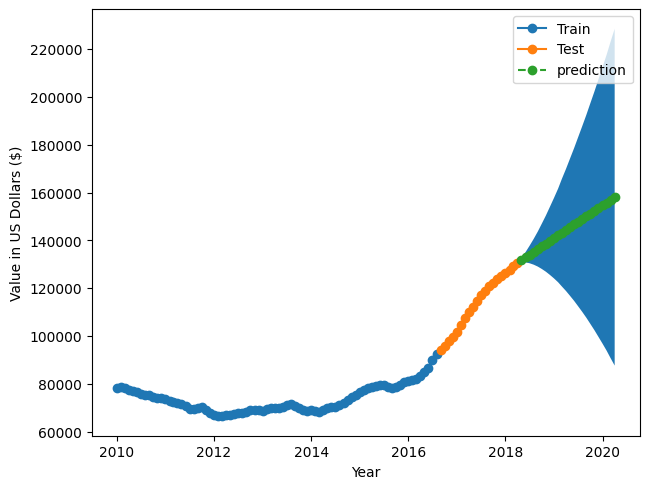

Mean Absolute Percentage Error of Above Model:
0.2587654453893385
------------------------------------------------------------

76103
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.48538D+00    |proj g|=  9.88604D-01

At iterate    5    f=  7.37251D+00    |proj g|=  1.76203D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   1.762D-05   7.373D+00
  F =   7.3725050514824728     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH            

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  76103   No. Observations:                  100
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -737.251
Date:                Fri, 17 Feb 2023   AIC                           1478.501
Time:                        03:44:38   BIC                           1483.671
Sample:                    01-01-2010   HQIC                          1480.592
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1509      0.039      3.879      0.000       0.075       0.227
sigma2       1.92e+05   2.45e+04      7.831      0.000    1.44e+05     2.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.47   Jarque-Bera (JB):                 1.05
Prob(Q):                              0.06   Prob(JB):                         0.59
Heteroskedasticity (H):               1.42   Skew:                             0.11
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

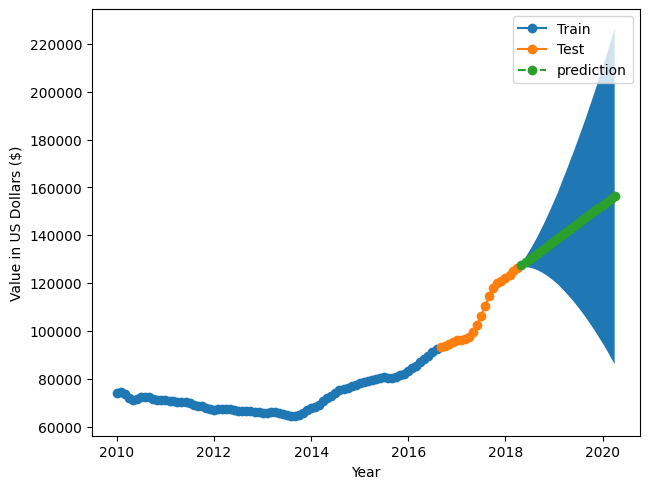

Mean Absolute Percentage Error of Above Model:
0.303788675024773
------------------------------------------------------------

75233
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70461D+00    |proj g|=  3.21621D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   6.569D-07   7.705D+00
  F =   7.7045073265583657     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/t

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75233   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -770.451
Date:                Fri, 17 Feb 2023   AIC                           1542.901
Time:                        03:44:39   BIC                           1545.486
Sample:                    01-01-2010   HQIC                          1543.947
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.944e+05    2.5e+04     15.763      0.000    3.45e+05    4.43e+05
===================================================================================
Ljung-Box (L1) (Q):                   9.19   Jarque-Bera (JB):               279.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.15   Skew:                             1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

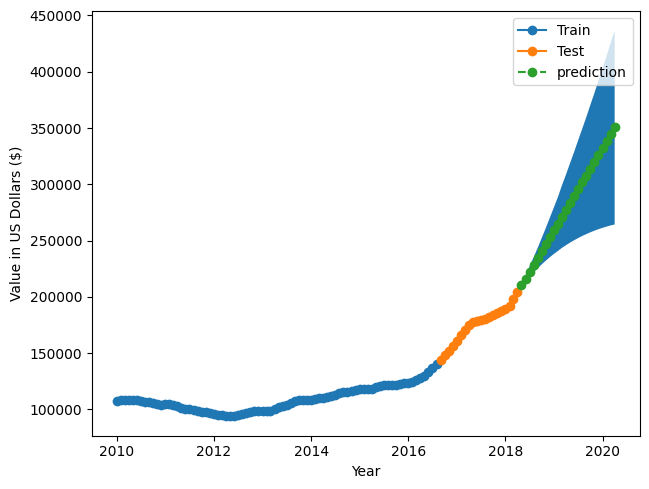

Mean Absolute Percentage Error of Above Model:
0.522185525018026
------------------------------------------------------------

78721
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.12157D+00    |proj g|=  2.10166D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   4.569D-07   8.121D+00
  F =   8.1214721016640041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/t

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  78721   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -812.147
Date:                Fri, 17 Feb 2023   AIC                           1626.294
Time:                        03:44:40   BIC                           1628.879
Sample:                    01-01-2010   HQIC                          1627.340
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.237e+05   1.32e+05      6.974      0.000    6.64e+05    1.18e+06
===================================================================================
Ljung-Box (L1) (Q):                   8.88   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.00   Prob(JB):                         0.94
Heteroskedasticity (H):               4.24   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

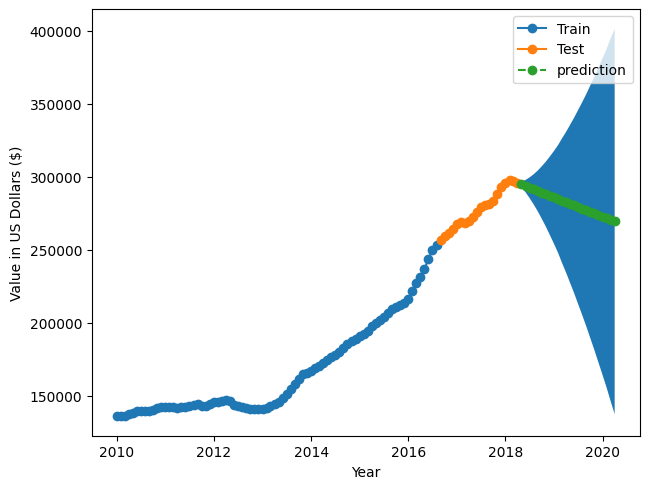

Mean Absolute Percentage Error of Above Model:
0.0639105451871887
------------------------------------------------------------

75141
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57923D+00    |proj g|=  3.65514D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   7.240D-07   7.579D+00
  F =   7.5791316479442674     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75141   No. Observations:                  100
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -757.913
Date:                Fri, 17 Feb 2023   AIC                           1517.826
Time:                        03:44:40   BIC                           1520.411
Sample:                    01-01-2010   HQIC                          1518.872
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.054e+05    4.2e+04      7.265      0.000    2.23e+05    3.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   7.77   Jarque-Bera (JB):                 2.51
Prob(Q):                              0.01   Prob(JB):                         0.29
Heteroskedasticity (H):               1.15   Skew:                             0.39
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

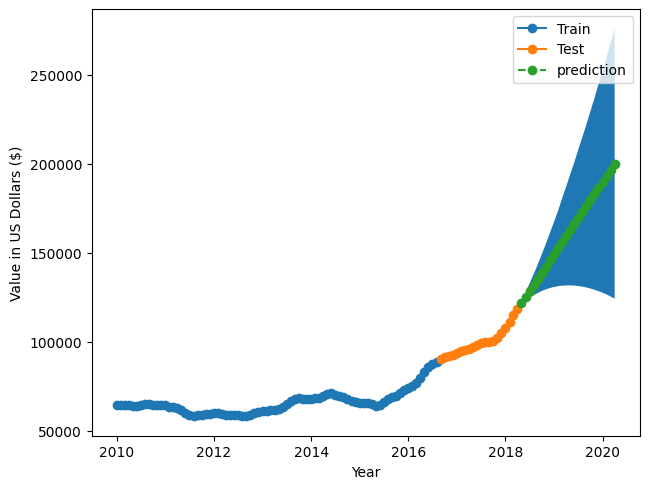

Mean Absolute Percentage Error of Above Model:
0.5359581769258643
------------------------------------------------------------



In [94]:
#implementing best model in a loop
RESULTS = {}

for zipcode in zipcode_list:
    print(zipcode)
    
    ## make empty dictionary for zipcode info
    zipcode_dictionary = {}
    
    ## create a copy of our data to model with, in case I need to reconfigure something
    training_data = reformatted_dataset[zipcode].copy()
    
    
    ## train test split, much like we set up previously
    train_size = 0.8
    split_idx = round(len(training_data)* train_size)

    train = training_data.iloc[:split_idx]
    test = training_data.iloc[split_idx:]
    
    
    ## get best parameters using auto_arima, just as we exemplified earlier
    gridsearch_model = auto_arima(training_data,start_p=0,start_q=0)
    best_model = SARIMAX(training_data,order=gridsearch_model.order,
                     seasonal_order=gridsearch_model.seasonal_order).fit()
    
    ## get predictions 2 years into the future (24 months)
    pred  = best_model.get_forecast(steps=24) #start=test.index[0],end=test.index[-1])
    pred_df = forecast_to_df(pred,zipcode)
    


    ## save info from dictionary made above into a table that can then be used to make graphs
    zipcode_dictionary['pred_df'] = pred_df
    zipcode_dictionary['model'] = best_model
    zipcode_dictionary['train'] = train
    zipcode_dictionary['test'] = test
    zipcode_dictionary['pred'] = pred.predicted_mean
    
    
    ## display results of each model using function defined above
    display(best_model.summary())
    plot_train_test_pred(train,test,pred_df)
    plt.xlabel('Year')
    plt.ylabel('Value in US Dollars ($)')
    plt.show()
    print('Mean Absolute Percentage Error of Above Model:')
    print(mean_absolute_percentage_error(test, pred.predicted_mean[0:20]))
   
    
    
    ## save dictionary info in RESULTS table
    RESULTS[zipcode] = zipcode_dictionary
    print('---'*20,end='\n\n')
    

Visually checking the forecast lines of each zipcode we have a top 10:

- 75141

- 75150

- 75217

- 75224

- 75228

- 75233

- 76112

- 76114

- 76117

- 78758

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9aa88ad0-b3b7-4bd6-b7a6-426ae47912b8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>